<a href="https://colab.research.google.com/github/Offliners/ML-writeup/blob/main/HW6/homework6-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 6 - Generative Adversarial Network**

This is the example code of homework 6 of the machine learning course by Prof. Hung-yi Lee.


In this homework, you are required to build a generative adversarial  network for anime face generation.


## Set up the environment


### Packages Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Fri Apr 23 14:50:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# You may replace the workspace directory if you want.
workspace_dir = './drive/MyDrive/HW6'

# Training progress bar
!pip install -q qqdm

### Download the dataset
**Please use the link according to the last digit of your student ID first!**

If all download links fail, please follow [here](https://drive.google.com/drive/folders/13T0Pa_WGgQxNkqZk781qhc5T9-zfh19e).

* To open the file using your browser, use the link below (replace the id first!):
https://drive.google.com/file/d/REPLACE_WITH_ID
* e.g. https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [4]:
!gdown --id 1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX --output "./crypko_data.zip"
# Other download links
#   Please uncomment the line according to the last digit of your student ID first

# 0
# !gdown --id 131zPaVoi-U--XThvzgRfaxrumc3YSBd3 --output "{workspace_dir}/crypko_data.zip"

# 1
# !gdown --id 1kCuIj1Pf3T2O94H9bUBxjPBKb---WOmH --output "{workspace_dir}/crypko_data.zip"

# 2
# !gdown --id 1boEoiiqBJwoHVvjmI0xgoutE9G0Rv8CD --output "{workspace_dir}/crypko_data.zip"

# 3
# !gdown --id 1Ic0mktAQQvnNAnswrPHsg-u2OWGBXTWF --output "{workspace_dir}/crypko_data.zip"

# 4
# !gdown --id 1PFcc25r9tLE7OyQ-CDadtysNdWizk6Yg --output "{workspace_dir}/crypko_data.zip"

# 5
# !gdown --id 1wgkrYkTrhwDSMdWa5NwpXeE4-7JaUuX2 --output "{workspace_dir}/crypko_data.zip"

# 6
# !gdown --id 19gwNYWi9gN9xVL86jC3v8qqNtrXyq5Bf --output "{workspace_dir}/crypko_data.zip"

# 7 
# !gdown --id 1-KPZB6frRSRLRAtQfafKCVA7em0_NrJG --output "{workspace_dir}/crypko_data.zip"

# 8
# !gdown --id 1rNBfmn0YBzXuG5ub7CXbsGwduZqEs8hx --output "{workspace_dir}/crypko_data.zip"

# 9
# !gdown --id 113NEISX-2j6rBd1yyBx0c3_9nPIzSNz- --output "{workspace_dir}/crypko_data.zip"


Downloading...
From: https://drive.google.com/uc?id=1XpV2G-vOpCH72NU0aWRDToJQf6HbQeBX
To: /content/crypko_data.zip
452MB [00:05, 87.4MB/s]


###Unzip the downloaded file.
The unzipped tree structure is like 
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [5]:
!unzip -q "./crypko_data.zip" -d "./"

## Random seed
Set the random seed to a certain value for reproducibility.

In [6]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## Import Packages
First, we need to import packages that will be used later.

Like hw3, we highly rely on **torchvision**, a library of PyTorch.

In [7]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

# For SNGAN
from torch.nn.utils import spectral_norm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [8]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


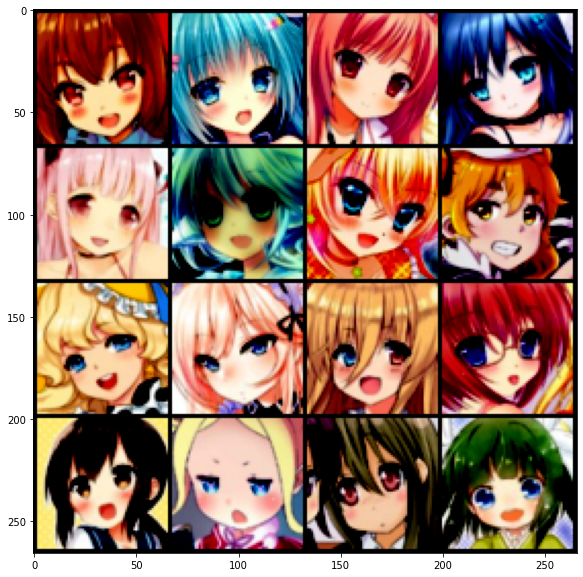

In [9]:
dataset = get_dataset(os.path.join('.', 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

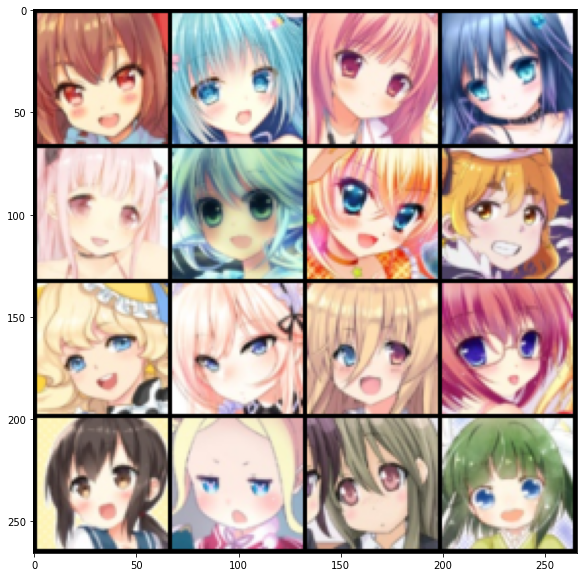

In [10]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use a simple CNN-based model structure. Feel free to modify your own model structure.

Note that the `N` of the input/output shape stands for the batch size.

In [29]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

class Generator(nn.Module):
    """Generator."""

    def __init__(self, batch_size, image_size=64, z_dim=100, conv_dim=64):
        super(Generator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        repeat_num = int(np.log2(self.imsize)) - 3
        mult = 2 ** repeat_num # 8
        layer1.append(spectral_norm(nn.ConvTranspose2d(z_dim, conv_dim * mult, 4)))
        layer1.append(nn.BatchNorm2d(conv_dim * mult))
        layer1.append(nn.ReLU())

        curr_dim = conv_dim * mult

        layer2.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer2.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer2.append(nn.ReLU())

        curr_dim = int(curr_dim / 2)

        layer3.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
        layer3.append(nn.BatchNorm2d(int(curr_dim / 2)))
        layer3.append(nn.ReLU())

        if self.imsize == 64:
            layer4 = []
            curr_dim = int(curr_dim / 2)
            layer4.append(spectral_norm(nn.ConvTranspose2d(curr_dim, int(curr_dim / 2), 4, 2, 1)))
            layer4.append(nn.BatchNorm2d(int(curr_dim / 2)))
            layer4.append(nn.ReLU())
            self.l4 = nn.Sequential(*layer4)
            curr_dim = int(curr_dim / 2)

        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.ConvTranspose2d(curr_dim, 3, 4, 2, 1))
        last.append(nn.Tanh())
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn( 128, 'relu')
        self.attn2 = Self_Attn( 64,  'relu')

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out=self.l1(z)
        out=self.l2(out)
        out=self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out, p1, p2


class Discriminator(nn.Module):
    """Discriminator, Auxiliary Classifier."""

    def __init__(self, batch_size=64, image_size=64, conv_dim=64):
        super(Discriminator, self).__init__()
        self.imsize = image_size
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(spectral_norm(nn.Conv2d(3, conv_dim, 4, 2, 1)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = conv_dim

        layer2.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        if self.imsize == 64:
            layer4 = []
            layer4.append(spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
            layer4.append(nn.LeakyReLU(0.1))
            self.l4 = nn.Sequential(*layer4)
            curr_dim = curr_dim*2
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)

        last.append(nn.Conv2d(curr_dim, 1, 4))
        self.last = nn.Sequential(*last)

        self.attn1 = Self_Attn(256, 'relu')
        self.attn2 = Self_Attn(512, 'relu')

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out,p1 = self.attn1(out)
        out=self.l4(out)
        out,p2 = self.attn2(out)
        out=self.last(out)

        return out.squeeze(), p1, p2

## Training

### Initialization
- hyperparameters
- model
- optimizer
- dataloader

In [30]:
# Training hyperparameters
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda()
lr = 1e-3

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 40 # 50
n_critic = 1 # 5
clip_value = 0.01
load_model = False
shift = 0

log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Model
G = Generator(batch_size=batch_size, image_size=64, z_dim=z_dim, conv_dim=64).cuda()
D = Discriminator(batch_size=batch_size, image_size=64, conv_dim=64).cuda()

# Load Model
if load_model:
  checkpoint_G = torch.load(os.path.join(ckpt_dir, f'G_{shift}.pth'))
  G.load_state_dict(checkpoint_G['model_state_dict'])
  loss_G = checkpoint_G['loss']

  checkpoint_D = torch.load(os.path.join(ckpt_dir, f'D_{shift}.pth'))
  D.load_state_dict(checkpoint_D['model_state_dict'])
  loss_D = checkpoint_D['loss']

G.train()
D.train()

# Loss
criterion = torch.nn.CrossEntropyLoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(filter(lambda p: p.requires_grad, D.parameters()), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

# Load Model
if load_model:
  opt_G.load_state_dict(checkpoint_G['optimizer_state_dict'])
  opt_D.load_state_dict(checkpoint_D['optimizer_state_dict'])

# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


RuntimeError: ignored

### Training loop
We store some pictures regularly to monitor the current performance of the Generator, and regularly record checkpoints.

In [ ]:
import torch.autograd as autograd

steps = 0
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda()

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda()
        r_imgs = Variable(imgs).cuda()
        f_imgs, _, _ = G(z)

        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs)).cuda()
        f_label = torch.zeros((bs)).cuda()

        # Model forwarding
        r_logit, _, _ = D(r_imgs.detach())
        f_logit, _, _ = D(f_imgs.detach())
        
        # Compute the loss for the discriminator.
        r_loss = criterion(r_logit, r_label)
        f_loss = criterion(f_logit, f_label)
        loss_D = (r_loss + f_loss) / 2

        # Gradient Penalty
        alpha = torch.FloatTensor(np.random.random((bs, 1, 1, 1))).cuda()
        interpolates = (alpha * r_imgs.detach() + ((1 - alpha) * f_imgs.detach())).requires_grad_(True)
        d_interpolates, _, _ = D(interpolates)
        fake = torch.ones((bs)).cuda()
        gradients = autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()


        # # WGAN Loss
        # loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs)) + 100 * gradient_penalty
       

        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        # for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda()
            f_imgs, _, _ = G(z)

            # Model forwarding
            f_logit, _, _ = D(f_imgs)
            
            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1
        
        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1+shift,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, f'Epoch_{epoch+1+shift:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    
    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    # Save the checkpoints.
    torch.save({'epoch': e+1+shift,
                'model_state_dict' : G.state_dict(),
                'optimizer_state_dict': opt_G.state_dict(),
                'loss': loss_G},
                os.path.join(ckpt_dir, f'G_{e+1+shift}.pth'))
    print(f'Saved G_{e+1+shift}.pth')
    
    torch.save({'epoch': e+1+shift,
                'model_state_dict' : D.state_dict(),
                'optimizer_state_dict': opt_D.state_dict(),
                'loss': loss_D},
                os.path.join(ckpt_dir, f'D_{e+1+shift}.pth'))
    print(f'Saved D_{e+1+shift}.pth')

## Inference
Use the trained model to generate anime faces!

### Load model 

In [ ]:
import torch

G = Generator(z_dim)
checkpoint_G = torch.load(os.path.join(ckpt_dir, 'G_100.pth'))
G.load_state_dict(checkpoint_G['model_state_dict'])

G.eval()
G.cuda()

### Generate and show some images.


In [ ]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda()
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(workspace_dir, 'logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(1000):
    torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')
  
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

from google.colab import files
files.download("images.tgz")